In [1]:
%matplotlib inline
import pandas as pd
import numpy as np;
import matplotlib.pyplot as plt
train=pd.read_csv("train.csv");
holdout=pd.read_csv("test.csv");


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_columns(df):
    process_missing(df);
    process_age(df);
    process_fare(df);
    process_titles(df);
    process_cabin(df);
   
    return df;
def create_dummy_columns(df):
    for each in ["Age_categories","Fare_categories","Title","Cabin_type","Sex"] :
        df=create_dummies(df,each);
    return df;

train=process_columns(train);
train=create_dummy_columns(train);
holdout=process_columns(holdout);
holdout=create_dummy_columns(holdout);

    

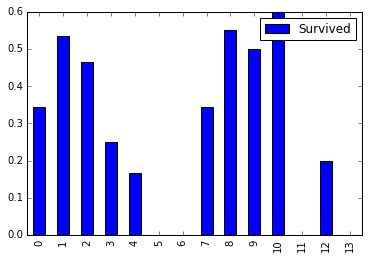

In [4]:
sibsp=train.pivot_table(index="SibSp",values="Survived");

parch=train.pivot_table(index="Parch", values="Survived");

min=pd.concat([sibsp,parch],ignore_index=True)

min.plot.bar();

plt.show()

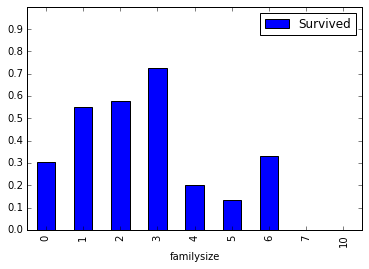

In [5]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index="familysize",values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [6]:
def process(df):
    df["isalone"]=explore["familysize"]==0;
    df.loc[df["isalone"]==True,"isalone"]=1;
    df.loc[df["isalone"]==False,"isalone"]=0;
process(train);
process(holdout)


In [9]:
from sklearn.feature_selection import RFECV 
from sklearn.ensemble import RandomForestClassifier
def select_feature(df):
    df.dropna(axis=0)
    df=df._get_numeric_data()
    columns=[];
    for each in df:
        columns.append(each);
    all_X=df.drop(['Survived','PassengerId'],axis=1)
    all_y=df["Survived"];
    rfc=RandomForestClassifier(random_state=1);
    selector=RFECV(rfc,cv=10);
    selector.fit(all_X,all_y);
    best_columns=all_X.columns[selector.support_];
    return best_columns;
best_columns=select_feature(train)
print(best_columns)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [10]:
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
def select_model(df,features):
    all_X=df[features];
    all_y=df["Survived"];
    model_name=[
        
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            "name": "LogisticRegression",
            "estimator":LogisticRegression(),
            "hyperparameters":
            {
                "solver":["newton-cg","lbfgs","liblinear"]
            }
        },
        {
            "name":"RandomForestClassifier",
            "estimator":RandomForestClassifier(),
            "hyperparameters":
            { 
                "n_estimators":[4,6,9],
                "criterion":["entropy","gini"],
                "max_depth" :[2,5,10],
                "max_features":["log2","sqrt"],
                "min_samples_leaf":[1,5,8],
                "min_samples_split":[2,3,5]
            }
        }
    ]
    best_model={} ;
    for each in model_name:
        temp={};
        grid=GridSearchCV(each["estimator"],param_grid=each["hyperparameters"],cv=10);
        grid.fit(all_X,all_y);
        temp["best_params"]=grid.best_params_;
        temp["best_score"]=grid.best_score_;
        temp["estimator"]=grid.best_estimator_;
        best_model[each["name"]]=temp;
    return best_model;
final_model=select_model(train,best_columns);
print(final_model);


{'LogisticRegression': {'best_params': {'solver': 'liblinear'}, 'best_score': 0.8204264870931538, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)}, 'RandomForestClassifier': {'best_params': {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_depth': 10, 'n_estimators': 9, 'max_features': 'log2', 'min_samples_split': 3}, 'best_score': 0.8406285072951739, 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)}, 'KNeighborsClas

In [24]:
def save_submission_file(model,features,filename):
    holdout_predictions=model.predict(holdout[features]);
    submission={"PasengerId":holdout["PassengerId"],
                "Survived":holdout_predictions};
    submission=pd.DataFrame(submission);
    submission.to_csv(filename,index=False);
model=final_model["RandomForestClassifier"]["estimator"];
save_submission_file(model,best_columns,"output.csv")

    